<a href="https://colab.research.google.com/github/urmilapol/urmilapolprojects/blob/master/animal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.vision import *

In [21]:
path = Path("/content/sample_data")
print(path)
for file, folder in [('cats.csv', 'Cats'), ('cows.csv', 'Cows'), 
                     ('dogs.csv', 'Dogs'), ('horses.csv', 'Horses')]:
    dest = path/folder # path + '/' + folder
    dest.mkdir(parents=True, exist_ok=True)
    download_images(path/file, dest)

/content/sample_data


In [22]:
for folder in ('Cats', 'Cows', 'Dogs', 'Horses'):
    print(folder)
    verify_images(path/folder, delete=True, max_size=500)

Cats


Cows


Dogs


Horses


In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [24]:
data.classes

['Cats', 'Cows', 'Dogs', 'Horses']

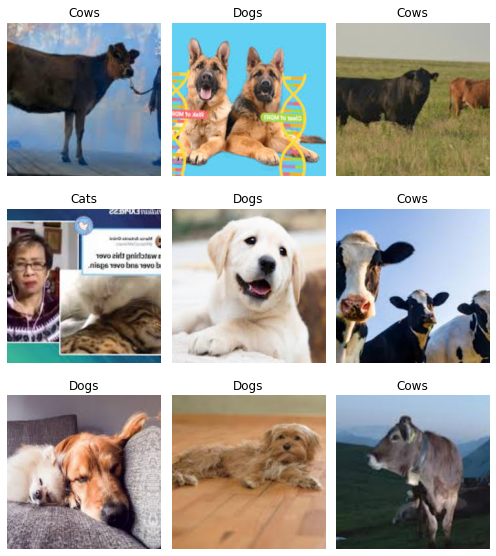

In [25]:
data.show_batch(rows=3, figsize=(7, 8))

In [28]:
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet50, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [29]:
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.151907,0.107845,0.039062,00:09
1,0.666349,0.200177,0.039062,00:08
2,0.461466,0.141870,0.039062,00:08
3,0.352327,0.130615,0.046875,00:08


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


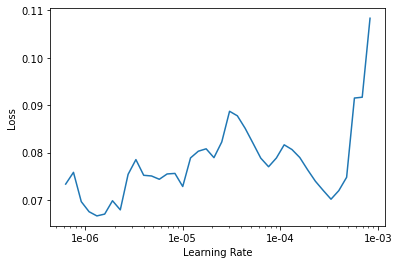

In [30]:
learn.unfreeze() # must be done before calling lr_find
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(4, max_lr=slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.107174,0.126156,0.039062,00:09
1,0.136765,0.132028,0.039062,00:08
2,0.104547,0.126749,0.031250,00:09
3,0.107697,0.123000,0.031250,00:09


In [0]:
learn.save('animal-detection-stage-1')

In [33]:
from fastai.widgets import *

ds, idxs = DatasetFormatter().from_toplosses(learn)
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [0]:
from fastai.vision import *

In [49]:
df = pd.read_csv('/content/sample_data/cleaned.csv', header='infer')
print(df.head())

                  name   label
0  Horses/00000047.jpg  Horses
1  Horses/00000113.jpg  Horses
2  Horses/00000108.jpg  Horses
3  Horses/00000030.jpg  Horses
4  Horses/00000129.jpg  Horses


In [54]:
db = (ImageItemList.from_df(df, path)
                   .random_split_by_pct(0.2)
                   .label_from_df()
                   .transform(get_transforms(), size=224)
                   .databunch(bs=8)).normalize(imagenet_stats)

NameError: ignored

In [0]:
print(data.classes, data.c, len(data.train_ds), len(data.valid_ds))
print(db.classes, db.c, len(db.train_ds), len(db.valid_ds))

In [0]:
db.show_batch()

In [0]:
learn.load('animal-detection-stage-1') # loading the weights
learn.data = db # replacing the data

learn.freeze()
learn.fit_one_cycle(4)

learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

learn.fit_one_cycle(4, max_lr=slice(3e-6, 3e-5))
learn.save('animal-detection-stage-2')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

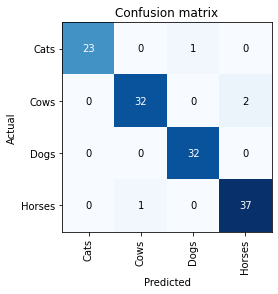

In [58]:
interp.plot_confusion_matrix()

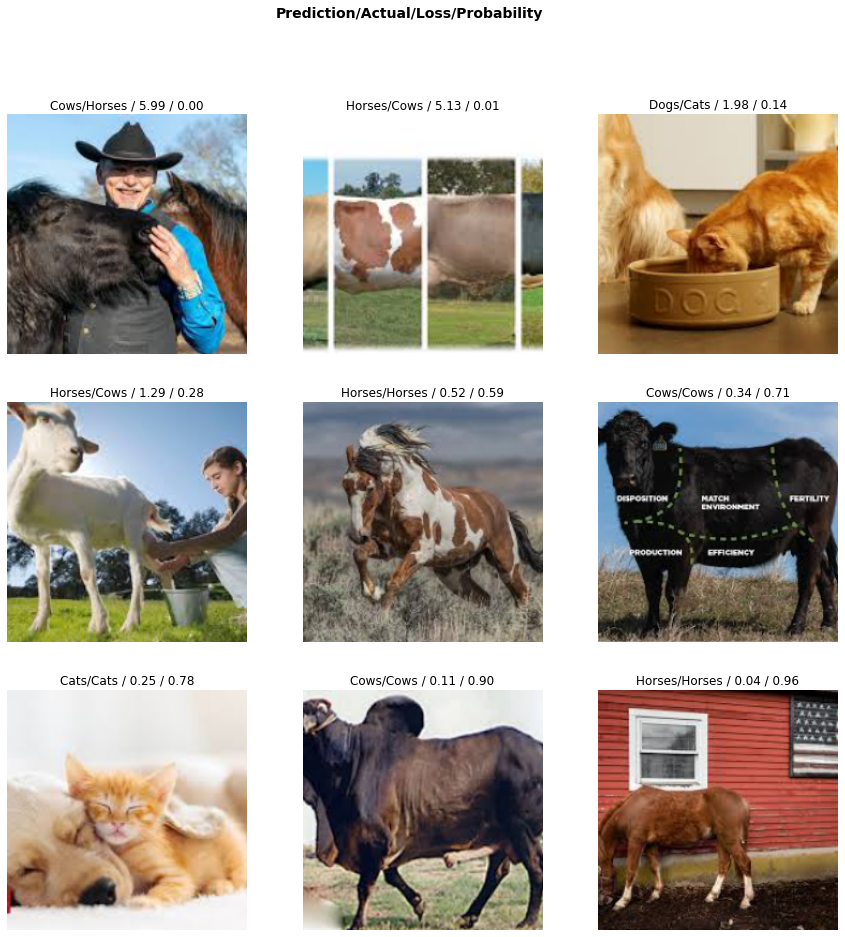

In [59]:
interp.plot_top_losses(9, figsize=(15,15))